In [1]:
root_path = './images/'
wpath = './models/'

In [2]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os
# from keras_utils import reset_tf_session
import tqdm_utils

In [3]:
# Extract image features
IMG_SIZE = 299

# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [4]:
# Define architecture
IMG_EMBED_SIZE = 2048
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = 1

In [5]:
class decoder:

    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    
    sentences = tf.placeholder('int32', [None, None])

    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')

    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    
    word_embed = L.Embedding(8769, WORD_EMBED_SIZE)
 
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
 
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
  
    token_logits = L.Dense(8769,
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds)) 

    word_embeds = word_embed(sentences[:, :-1]) 
    
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))
    
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS]) 

    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states)) 

    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])

    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s
s = tf.Session()
# will be used to save/load network weights.
saver = tf.train.import_meta_graph(wpath + 'weights_11.meta')

In [7]:
class final_model:
    # CNN encoder 
    encoder, preprocess_for_model = get_cnn_encoder()

    saver.restore(s, os.path.abspath(wpath + "weights_11"))
    
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")

    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    img_embeds = encoder(input_images)

    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)

    current_word = tf.placeholder('int32', [1], name='current_input')

    word_embed = decoder.word_embed(current_word)

    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))

    new_probs = tf.nn.softmax(new_logits)

    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from C:\Users\Azhar\Desktop\ml\Final Year  Project\Captionizer\models\weights_11


In [8]:
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [9]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [10]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

FailedPreconditionError: Error while reading resource variable conv2d_18/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/conv2d_18/kernel/class tensorflow::Var does not exist.
	 [[node model/conv2d_18/Conv2D/ReadVariableOp (defined at c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'model/conv2d_18/Conv2D/ReadVariableOp':
  File "C:\Users\Azhar\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Azhar\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Azhar\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\Azhar\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\Azhar\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-5616e52abb2d>", line 1, in <module>
    class final_model:
  File "<ipython-input-7-5616e52abb2d>", line 13, in final_model
    img_embeds = encoder(input_images)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\keras\engine\network.py", line 695, in call
    return self._run_internal_graph(inputs, training=training, mask=mask)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\keras\engine\network.py", line 844, in _run_internal_graph
    output_tensors = layer(computed_tensors, **kwargs)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\keras\layers\convolutional.py", line 197, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\nn_ops.py", line 1134, in __call__
    return self.conv_op(inp, filter)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\nn_ops.py", line 639, in __call__
    return self.call(inp, filter)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\nn_ops.py", line 238, in __call__
    name=self.name)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\nn_ops.py", line 2010, in conv2d
    name=name)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 528, in _apply_op_helper
    preferred_dtype=default_dtype)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1297, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1789, in _dense_var_to_tensor
    return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1214, in _dense_var_to_tensor
    return self.value()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 524, in value
    return self._read_variable_op()
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 608, in _read_variable_op
    self._dtype)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\ops\gen_resource_variable_ops.py", line 587, in read_variable_op
    "ReadVariableOp", resource=resource, dtype=dtype, name=name)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "c:\users\azhar\desktop\ml\final year  project\captionizer\captionizer\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


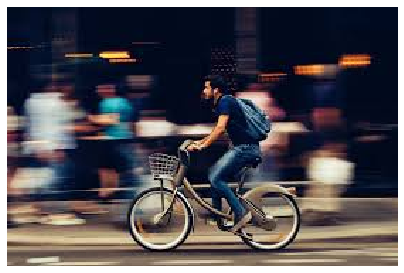

In [11]:
apply_model_to_image_raw_bytes(open(root_path + "street.jpg", "rb").read())